In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


In [2]:
def f(x):
    return 3*x**2-4*x+5

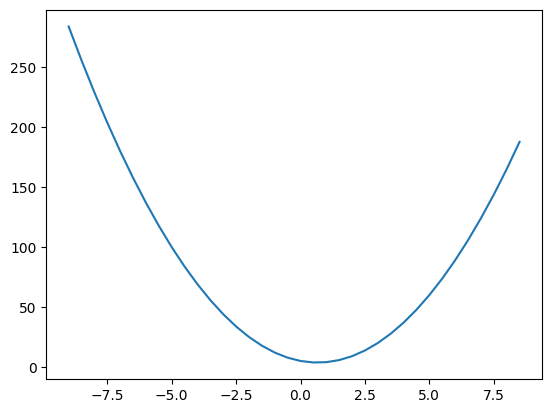

In [5]:
xs=np.arange(-9,9,0.5)
ys=f(xs)
plt.plot(xs,ys)

In [73]:
import math
class Value:
    def __init__(self,data,_children=(),_op="",label=""):
        self.data=data
        self._prev=set(_children)
        self.grad=0
        self._backward=lambda:None
        self._op=_op
        self.label=label
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        other=other if isinstance(other,Value) else Value(other)
        out=Value(self.data+other.data,(self,other),"+")
        def _backward():
            self.grad+=1.0*out.grad
            other.grad+=1.0*out.grad
        out._backward=_backward
        return out
    def __mul__(self,other):
        other=other if isinstance(other,Value) else Value(other)
        out=Value(self.data*other.data,(self,other),"*")
        def _backward():
            self.grad+=(other.data)*out.grad
            other.grad+=(self.data)*out.grad
        out._backward=_backward
        return out
    def __rmul__(self,other):
        return self*other
    def __radd__(self,other):
        return self+other
    def tanh(self):
        x=self.data
        t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
        out=Value(t,(self,),"tanh")
        def _backward():
            self.grad+=(1-t**2)*out.grad
        out._backward=_backward
        return out
    def exp(self):
        x=self.data
        out=Value(math.exp(x),(self,),"exp")
        def _backward():
            self.grad+=out.data*out.grad
        out._backward=_backward
        return out
    def __truediv__(self,other):
        return self*(other**-1)
    def __pow__(self,other):
        assert isinstance(other,(int,float)),"Only int and float values are allowed!"
        out=Value(self.data**other,(self,),f"**{other}")
        def _backward():
            self.grad+=other*self.data**(other-1)*out.grad
        out._backward=_backward
        return out
    def __neg__(self):
        return self*-1
    def __sub__(self,other):
        return self+(-other)
    def backward(self):
        topo=[]
        visited=set()
        self.grad=1.0
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        for node in reversed(topo):
            node._backward()
        

In [56]:
a=Value(2)
2*a

Value(data=4)

In [65]:
a=Value(4)
b=Value(2)
b/a

Value(data=0.5)

In [67]:
b-a

Value(data=-2)

In [51]:
from graphviz import Digraph


def trace(root):
    nodes,edges=set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges
    
    
def draw_dot(root):
    dot=Digraph(format="svg",graph_attr={'rankdir':'LR'})
    nodes,edges=trace(root)
    for n in nodes:
        uid=str(id(n))
        dot.node(name=uid,label="{%s | Data %.4f | Grad %.4f}" %(n.label,n.data,n.grad),shape="record")
        if n._op:
            dot.node(name=uid+n._op,label=n._op)
            dot.edge(uid+n._op,uid)
    for n1,n2 in edges:
        dot.edge(str(id(n1)),str(id(n2))+n2._op)
    return dot
        


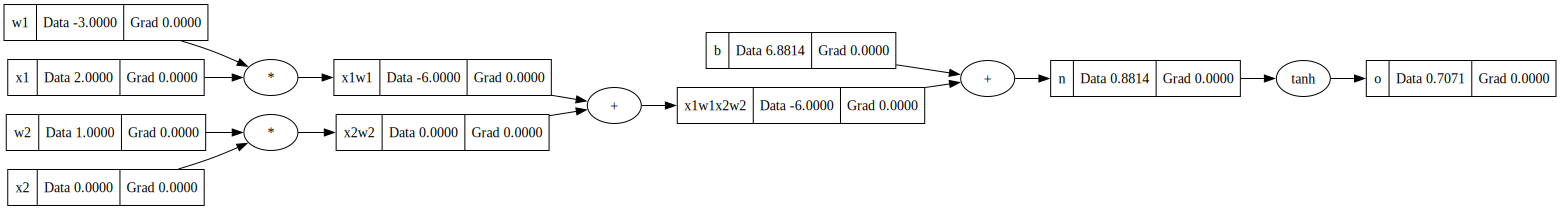

In [52]:
x1=Value(2.0,label="x1")
x2=Value(0.0,label="x2")

w1=Value(-3.0,label="w1")
w2=Value(1.0,label="w2")

b=Value(6.8813735870,label="b")
x1w1=x1*w1;x1w1.label="x1w1"
x2w2=x2*w2;x2w2.label="x2w2"
x1w1x2w2=x1w1+x2w2; x1w1x2w2.label="x1w1x2w2"

n=x1w1x2w2+b;n.label="n"

o=n.tanh();o.label="o"
draw_dot(o)

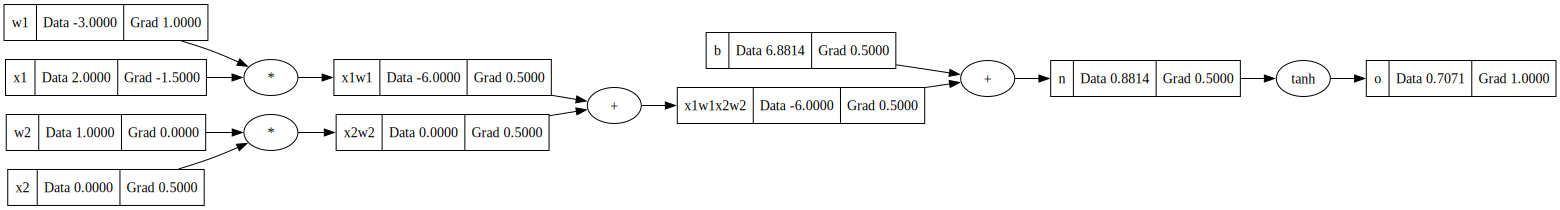

In [53]:
o.backward()
draw_dot(o)

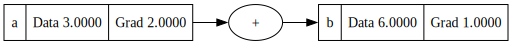

In [54]:
a=Value(3.0,label="a")
b=a+a;b.label="b"
b.backward()

draw_dot(b)

In [68]:
import torch
x1=torch.tensor([2.0]).double();x1.requires_grad=True
w1=torch.tensor([-3.0]).double();w1.requires_grad=True
x2=torch.tensor([0.0]).double();x2.requires_grad=True
w2=torch.tensor([1.0]).double();w2.requires_grad=True
b=torch.tensor([6.8813735870]).double();b.requires_grad=True

n=(x1*w1)+(x2*w2)+b
o=torch.tanh(n)

print(o.data.item())
print(o.backward())


0.7071066904050358
None


In [118]:
import random
class Neuron:
    def __init__(self,num_inputs):
        self.w=[Value(random.uniform(-1,1)) for _ in range(num_inputs)]
        self.b=Value(random.uniform(-1,1))
    def __call__(self,x):
        act=sum(wi*xi for wi,xi in zip(self.w,x))+self.b
        out=act.tanh()
        return out
    def parameters(self):
        return self.w+[self.b]

class Layer:
    def __init__(self,num_inputs,num_outputs):
        self.neurons=[Neuron(num_inputs=num_inputs) for _ in range(num_outputs)]
    def __call__(self,x):
        outs=[n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

class MLP:
    def __init__(self,num_inputs,num_outputs):
        sz=[num_inputs]+num_outputs
        self.layers=[Layer(sz[i],sz[i+1]) for i in range(len(num_outputs))]
    def __call__(self,x):
        for layer in self.layers:
            x=layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        



In [236]:
mlp=MLP(3,[4,4,1])

In [237]:
xs=[
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]
ys=[1.0,-1.0,-1.0,1.0]

In [233]:
ypred=[mlp(x) for x in xs]
ypred

[Value(data=0.9742759969835745),
 Value(data=-0.9953124363034941),
 Value(data=-0.9991515158810317),
 Value(data=0.9938703817340755)]

In [234]:
loss=sum([(yout-yexp)**2 for yexp,yout in zip(ys,ypred)])
loss

Value(data=0.0007219897299839664)

In [235]:
loss.backward()

In [232]:
h=0.01
for p in mlp.parameters():
    p.data+=-h*p.grad   

In [238]:
learning_rate=0.05
def train_neural_net():
    for k in range(20):
        
        #forward pass
        ypred=[mlp(x) for x in xs]
        loss=sum((yout-yexp)**2 for yexp,yout in zip(ys,ypred))
        
        #zero_grad
        for p in mlp.parameters():
            p.grad=0.0
            
        #backward pass   
        loss.backward()

        #update
        for p in mlp.parameters():
            p.data+= -learning_rate * p.grad
        print(k,loss.data)   
train_neural_net()




0 7.114655676392366
1 6.21118758369859
2 3.458200961544067
3 1.4066820844440975
4 0.7518749919326596
5 0.32692306708622404
6 0.23878304388243812
7 0.18701135914607178
8 0.15271678557127763
9 0.12849126268559602
10 0.11055332313811023
11 0.09678348355661795
12 0.08590813775974954
13 0.07711892063966055
14 0.06987957385334484
15 0.06382115217946671
16 0.05868195095002537
17 0.05427145253304693
18 0.050447829795374516
19 0.047103431984896284


In [239]:
ypred

[Value(data=0.9742759969835745),
 Value(data=-0.9953124363034941),
 Value(data=-0.9991515158810317),
 Value(data=0.9938703817340755)]